In [1]:
pip install torch==1.11.0

     |████████████████████████████████| 750.6 MB 9.4 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.3.0 requires torch<1.8,>=1.7.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.3.0 requires torch<1.9.0,>=1.6.0, but you have torch 1.11.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision==0.12.0

     |████████████████████████████████| 21.0 MB 880 kB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.1
    Uninstalling torchvision-0.8.1:
      Successfully uninstalled torchvision-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.3.0 requires torch<1.8,>=1.7.0, but you have torch 1.11.0 which is incompatible.
fastai 2.3.0 requires torchvision<0.9,>=0.8, but you have torchvision 0.12.0 which is incompatible.
allennlp 2.3.0 requires torch<1.9.0,>=1.6.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.3.0 requires torchvision<0.10.0,>=0.8.1, but you have torchvision 0.12.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **1. Data Reading**

In [4]:
example = '../input/garbage-classification/Garbage classification/Garbage classification/glass/glass1.jpg'
path = '../input/garbage-classification/Garbage classification/Garbage classification'

Shape: (384, 512, 3)


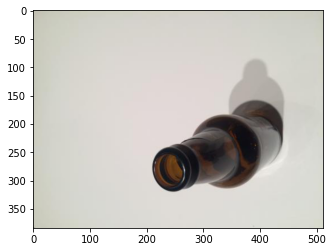

In [5]:
img = mpimg.imread(example)
print('Shape:', img.shape)
plt.imshow(img);

Histograms

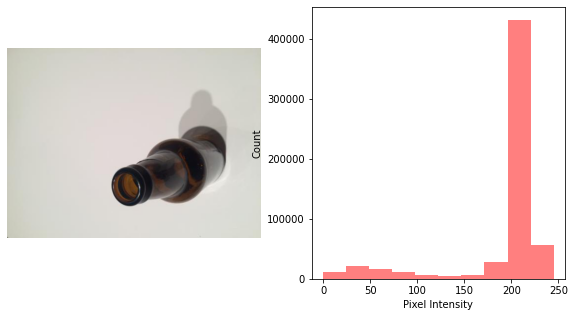

In [6]:
def plotHist(img):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.axis('off')
  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, alpha=0.5, color='r')

plotHist(img)

# **2. Data Augmentation**


In [7]:
transformer = {
    'original': transform.Compose([
        transform.Resize((224, 224)),
        transform.ToTensor(), 
        transform.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
]), 
   'dataset1': transform.Compose([
       transform.Resize((224, 224)),
       transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
       transform.RandomRotation(5),
       transform.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
       transform.ToTensor(),
       transform.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225))
])
}

In [9]:
bs = 64

original = ImageFolder(path, transform=transformer['original'])

#all_set = train_val + test
train_val, test = train_test_split(original, test_size=0.2, shuffle=True, random_state=43)

#train_val = train + val + dataset1 + dataset2 + dataset3
train_val = ConcatDataset([train_val, 
                           ImageFolder(path, transform=transformer['dataset1'])]) 

train, val = train_test_split(train_val, test_size=0.1, shuffle=True, random_state=43)

loaders = {
    'train': DataLoader(train, batch_size=bs, num_workers=4, pin_memory=False),
    'val': DataLoader(val, batch_size=bs, num_workers=4, pin_memory=False),
    'test': DataLoader(test, batch_size=bs, num_workers=4, pin_memory=False)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val), 
    'test': len(test),
}

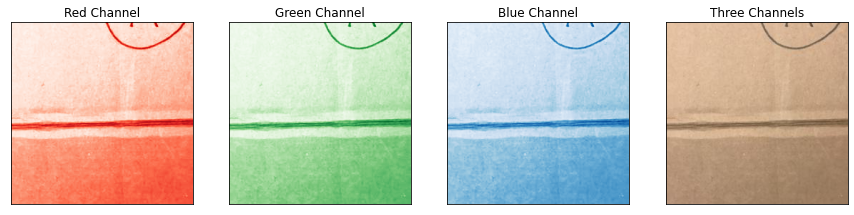

In [10]:
exampleset = ImageFolder(path, transform=transform.Compose([transform.ToTensor(),
                                                            transform.CenterCrop(255),]))

x, y = next(iter(DataLoader(exampleset)))

channels = ['Red', 'Green', 'Blue']
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, axs in enumerate(fig.axes[:3]):
    axs.imshow(x[0][i,:,:], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    axs.set_xticks([])
    axs.set_yticks([])
    
ax[3].imshow(x[0].permute(1,2,0))
ax[3].set_title('Three Channels')
ax[3].set_xticks([])
ax[3].set_yticks([]);

In [11]:
channels = 3

for channel in range(channels):
    for x in ['train', 'val', 'test']:
        #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
        num_pxl = dataset_sizes[x]*220*220
    
        #Go through the butches and sum up the pixels of the objects, 
        #which then divide the sum by the number of all pixels to calculate the average
        total_sum = 0
        for batch in loaders[x]:
            layer = list(map(itemgetter(channel), batch[0]))
            layer = torch.stack(layer, dim=0)
            total_sum += layer.sum()
        mean = total_sum / num_pxl

        #we calculate the standard deviation using the formula that I indicated above
        sum_sqrt = 0
        for batch in loaders[x]: 
            layer = list(map(itemgetter(channel), batch[0]))
            sum_sqrt += ((torch.stack(layer, dim=0) - mean).pow(2)).sum()
        std = torch.sqrt(sum_sqrt / num_pxl)
        
        print(f'|channel:{channel+1}| {x} - mean: {mean}, std: {std}')

|channel:1| train - mean: 0.19911257922649384, std: 1.4702599048614502
|channel:1| val - mean: 0.2307642102241516, std: 1.4615684747695923
|channel:1| test - mean: 0.8583348393440247, std: 0.9167242646217346
|channel:2| train - mean: 0.21673594415187836, std: 1.4558736085891724
|channel:2| val - mean: 0.2570776045322418, std: 1.4520564079284668
|channel:2| test - mean: 0.8631734848022461, std: 0.94581139087677
|channel:3| train - mean: 0.31598812341690063, std: 1.449414849281311
|channel:3| val - mean: 0.36602139472961426, std: 1.4511668682098389
|channel:3| test - mean: 0.9321960210800171, std: 1.0451407432556152


In [12]:
x, y = next(iter(loaders['train']))
x.mean(),  x.std()

(tensor(0.3746), tensor(1.4266))

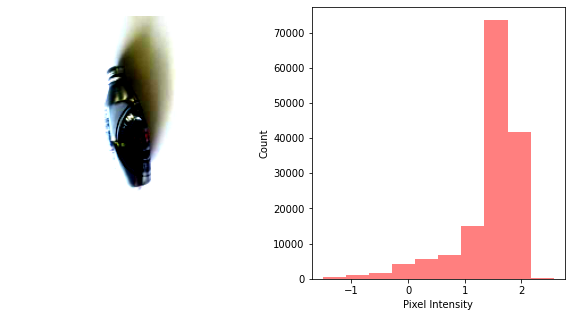

In [13]:
x, y = next(iter(loaders['train']))
img_norm = x[0].permute(1,2,0).numpy()
plotHist(img_norm)

In [14]:
print('Classes:', original.classes)
print('Number of classes:', len(original.classes))

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of classes: 6


In [15]:
dic = {}

for classes in original.classes:
  dic[classes] = [len([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)])]

samplesize = pd.DataFrame.from_dict(dic)

In [16]:
samplesize

,cardboard,glass,metal,paper,plastic,trash
0,403,501,410,594,482,137


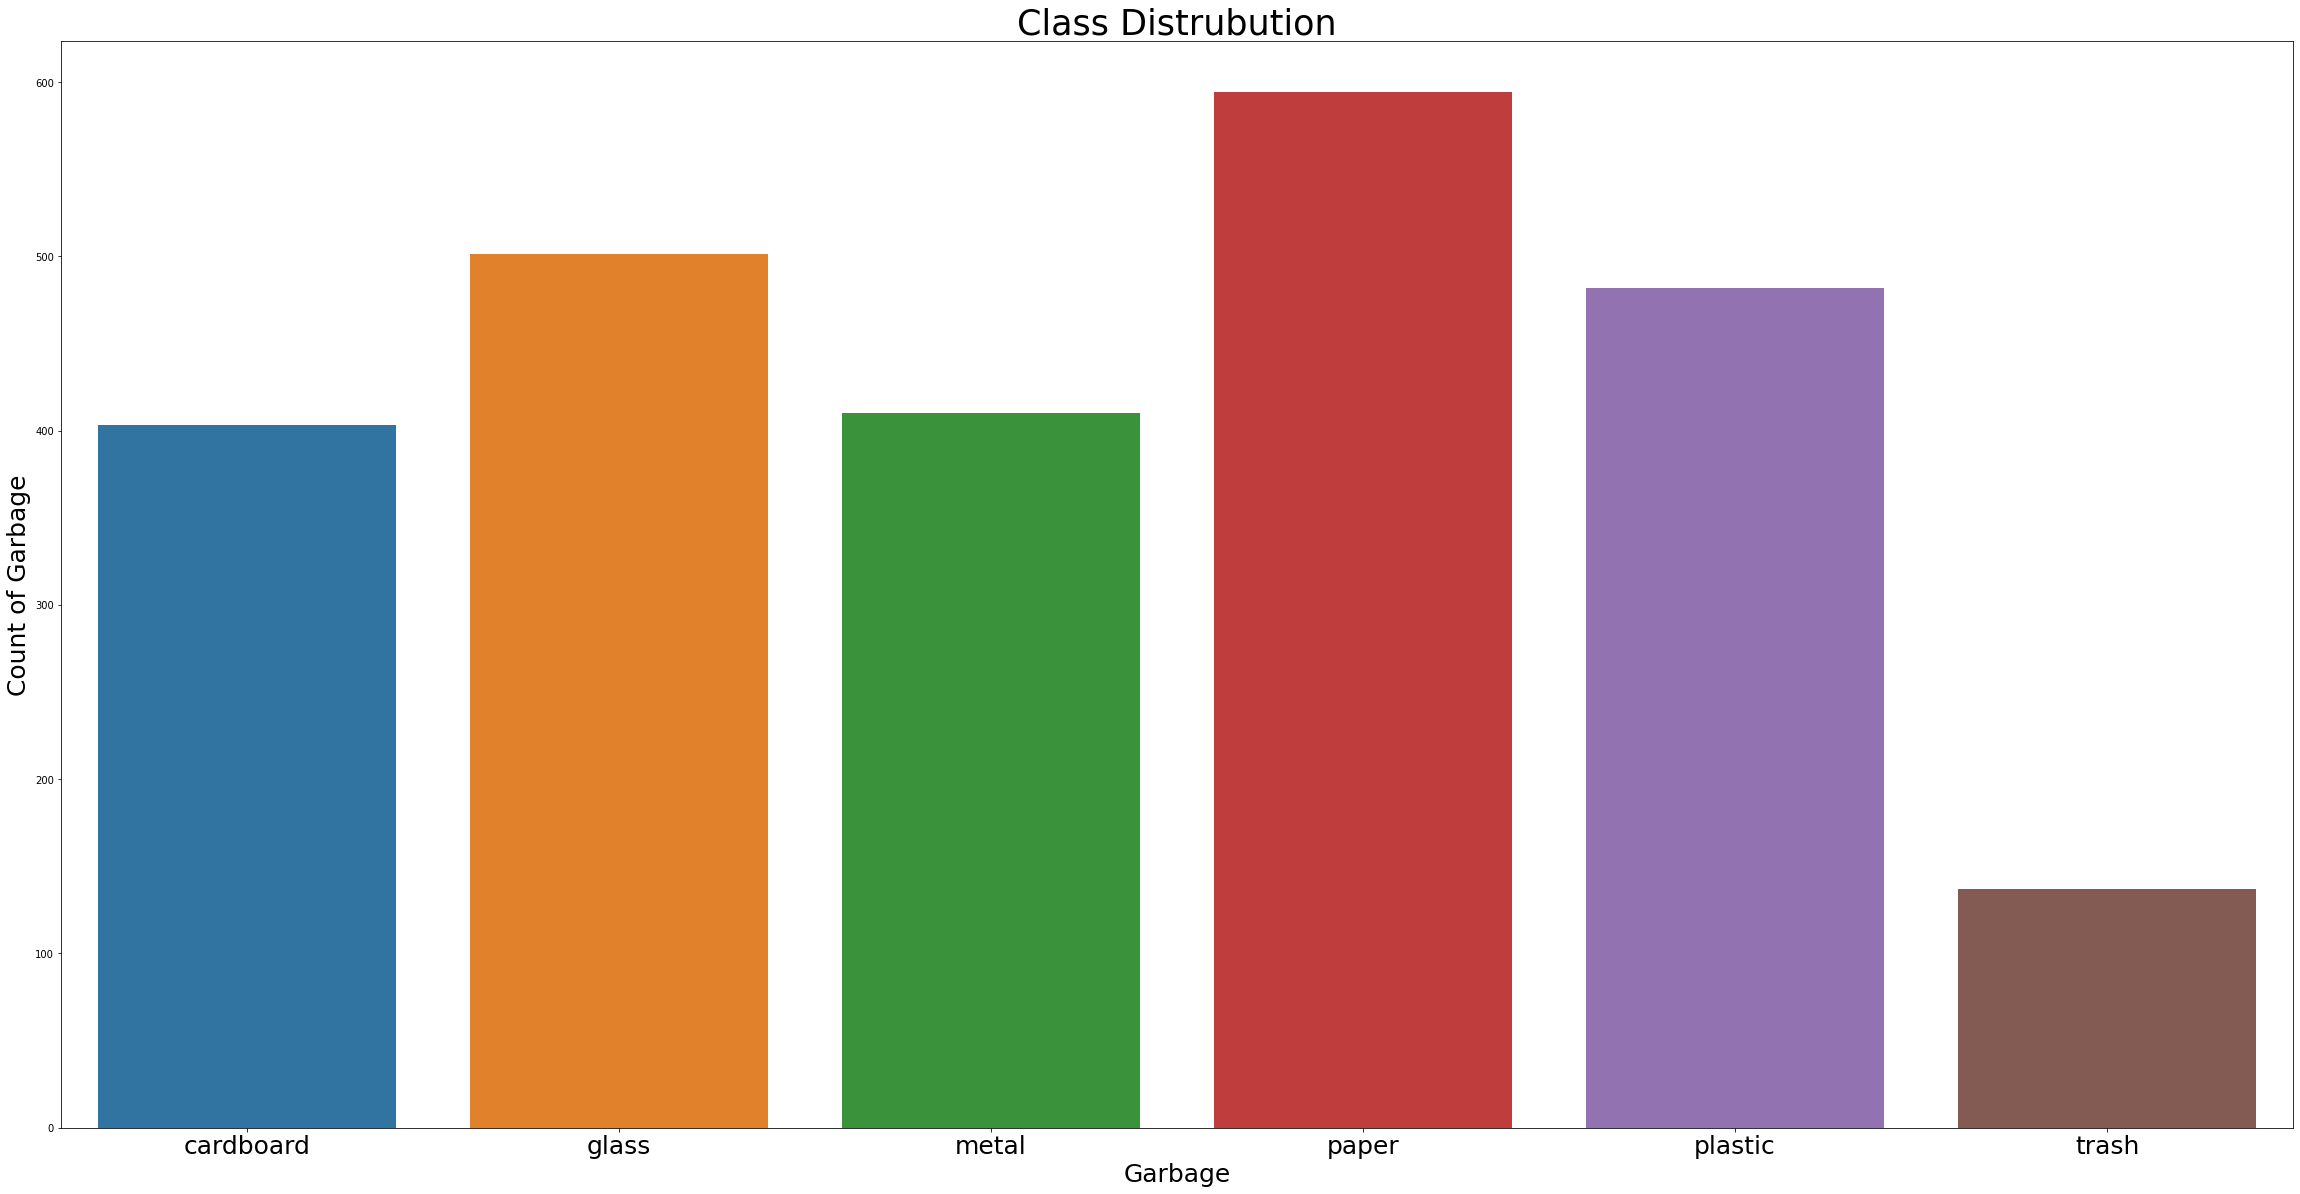

In [17]:
figure_size = plt.rcParams['figure.figsize']
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams['figure.figsize'] = figure_size

sns.barplot(data=samplesize)

index = np.arange(len(original.classes))

plt.xlabel('Garbage', fontsize=25)
plt.ylabel('Count of Garbage', fontsize=25)
plt.xticks(index, original.classes, fontsize=25)
plt.title('Class Distrubution', fontsize=35)
plt.show()

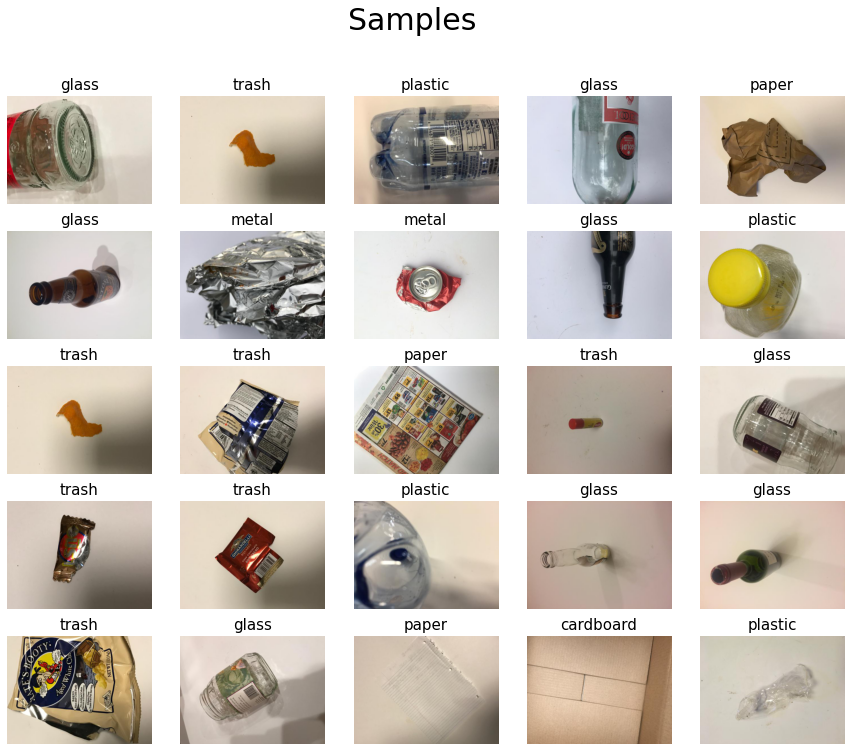

In [18]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1
  

rand_samples = [] 
for _ in range(25): 
    classes = random.choice(original.classes)
    rand_samples.append([random.sample([os.path.join(path+'/'+classes, filename) for filename in os.listdir(path+'/'+classes)], 1), classes]) 
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.show()

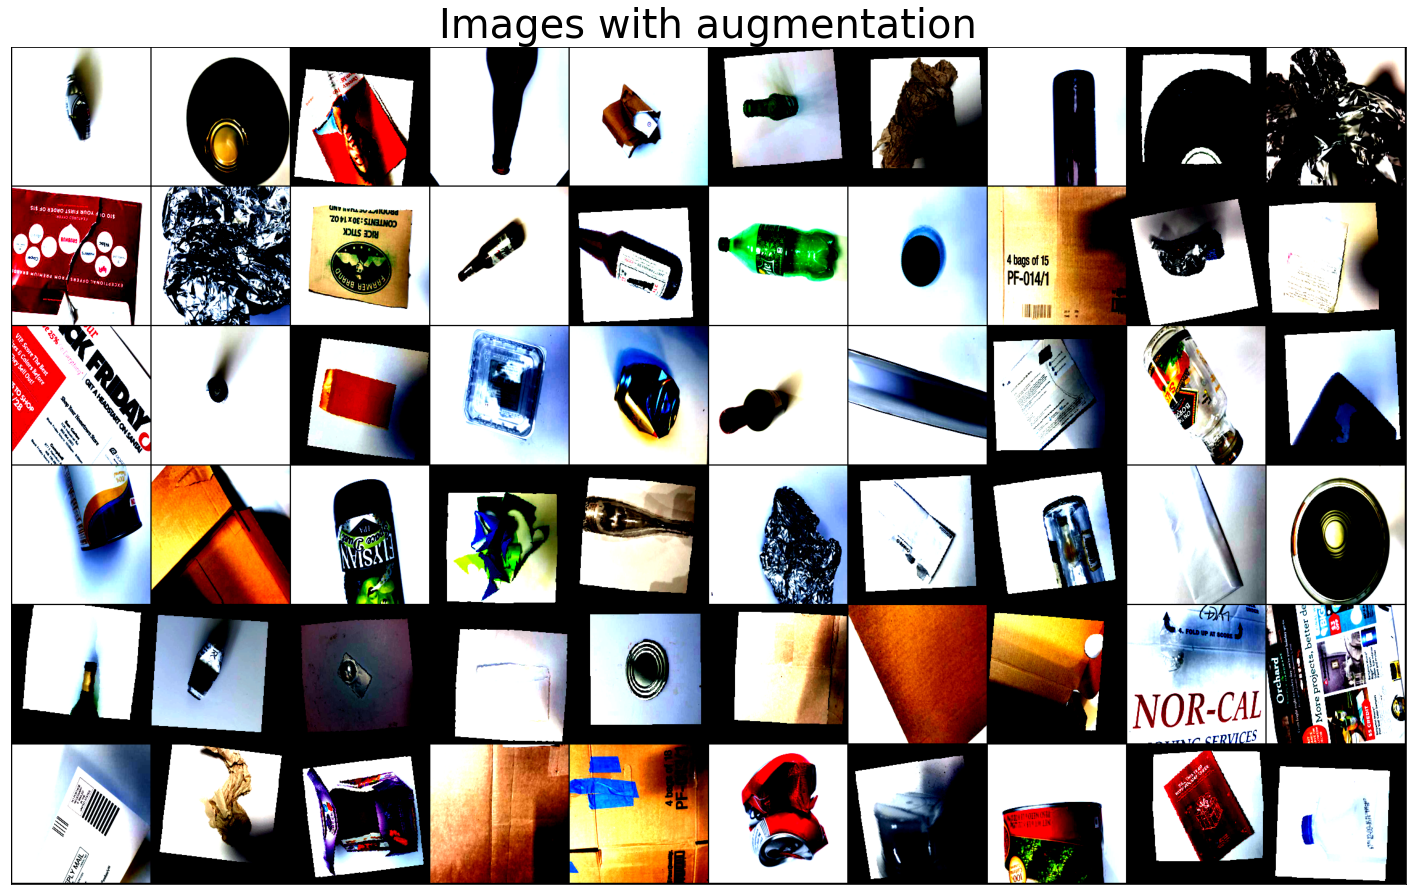

In [19]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(25, 25))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        ax.set_title('Images with augmentation', fontsize=40)
        break
        
show_batch(loaders['train'])

# 3. Training and Testing

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [21]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
lr = []

In [22]:
def train(seed, epochs, model):
    
  print('Creating a model {}...'.format(seed))

  model.to(device)  
  criterion = nn.CrossEntropyLoss()
  if seed==2:
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay = 1e-5)
  else:
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
  #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.1, epochs=epochs, steps_per_epoch=len(loaders['train']), cycle_momentum=True)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
#             lr.append(scheduler.get_lr())
#             scheduler.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
          acc = 100. * running_corrects.double() / dataset_sizes[phase]
          scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
      lr.append(scheduler._last_lr)
        
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    #scheduler.step() 
  time_elapsed = time.time() - since
  print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)


  model.load_state_dict(best_model)

  for param in model.parameters():
        param.requires_grad=True

  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)  
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
  #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, epochs=epochs, steps_per_epoch=len(loaders['train']), cycle_momentum=True)
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
#             lr.append(scheduler.get_lr())
#             scheduler.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
        acc = 100. * running_corrects.double() / dataset_sizes[phase]
        scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
      lr.append(scheduler._last_lr)
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)    
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    #scheduler.step() 
  time_elapsed = time.time() - since
  print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)

  model.load_state_dict(best_model)
  return model

# Model

**1. DenseNet(1)**

In [23]:
densenet121_0 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_0.parameters():
  param.requires_grad=False

densenet121_0.classifier = nn.Linear(in_features=densenet121_0.classifier.in_features, out_features=len(original.classes), bias=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

**2. Convnext**

In [24]:
convnext = torchvision.models.convnext_tiny (pretrained=True)
for param in convnext.parameters():
  param.grad_requires = False
convnext.classifier[2] = nn.Linear(in_features=768,out_features=6, bias=True)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

**3. ResNet**

In [25]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=len(original.classes), bias=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

**Start Training**

In [26]:
num_models = 3
epochs = 10

# models = [densenet121_0, densenet121_1, googlenet, resnet101, vgg19_bn]
models = [convnext, densenet121_0,resnet101]

for seed in range(num_models):
   train(seed=seed, epochs=epochs, model=models[seed])

Creating a model 0...
Epoch: 1/10
train - loss:0.8499030404151462, accuracy0.7268507207427315
val - loss:0.46829167519296916, accuracy0.8593406593406593
Time: 1.0m 32.557775259017944s
Epoch: 2/10
train - loss:0.42146914162701044, accuracy0.8734424627412656
val - loss:0.3559115741770346, accuracy0.8945054945054945
Time: 3.0m 5.356111526489258s
Epoch: 3/10
train - loss:0.33505850693225975, accuracy0.9003176154409969
val - loss:0.3078898287818327, accuracy0.9076923076923077
Time: 4.0m 38.385704040527344s
Epoch: 4/10
train - loss:0.2863908199497403, accuracy0.9088688003909113
val - loss:0.279104880047041, accuracy0.9142857142857143
Time: 6.0m 11.10435175895691s
Epoch: 5/10
train - loss:0.24820549946643308, accuracy0.9201075006107989
val - loss:0.2569612657098652, accuracy0.9186813186813186
Time: 7.0m 43.85840845108032s
Epoch: 6/10
train - loss:0.22111384528003053, accuracy0.9345223552406547
val - loss:0.2417975004598662, accuracy0.9186813186813186
Time: 9.0m 16.49564504623413s
Epoch: 7/10


# 4. Training and Loss Visualization

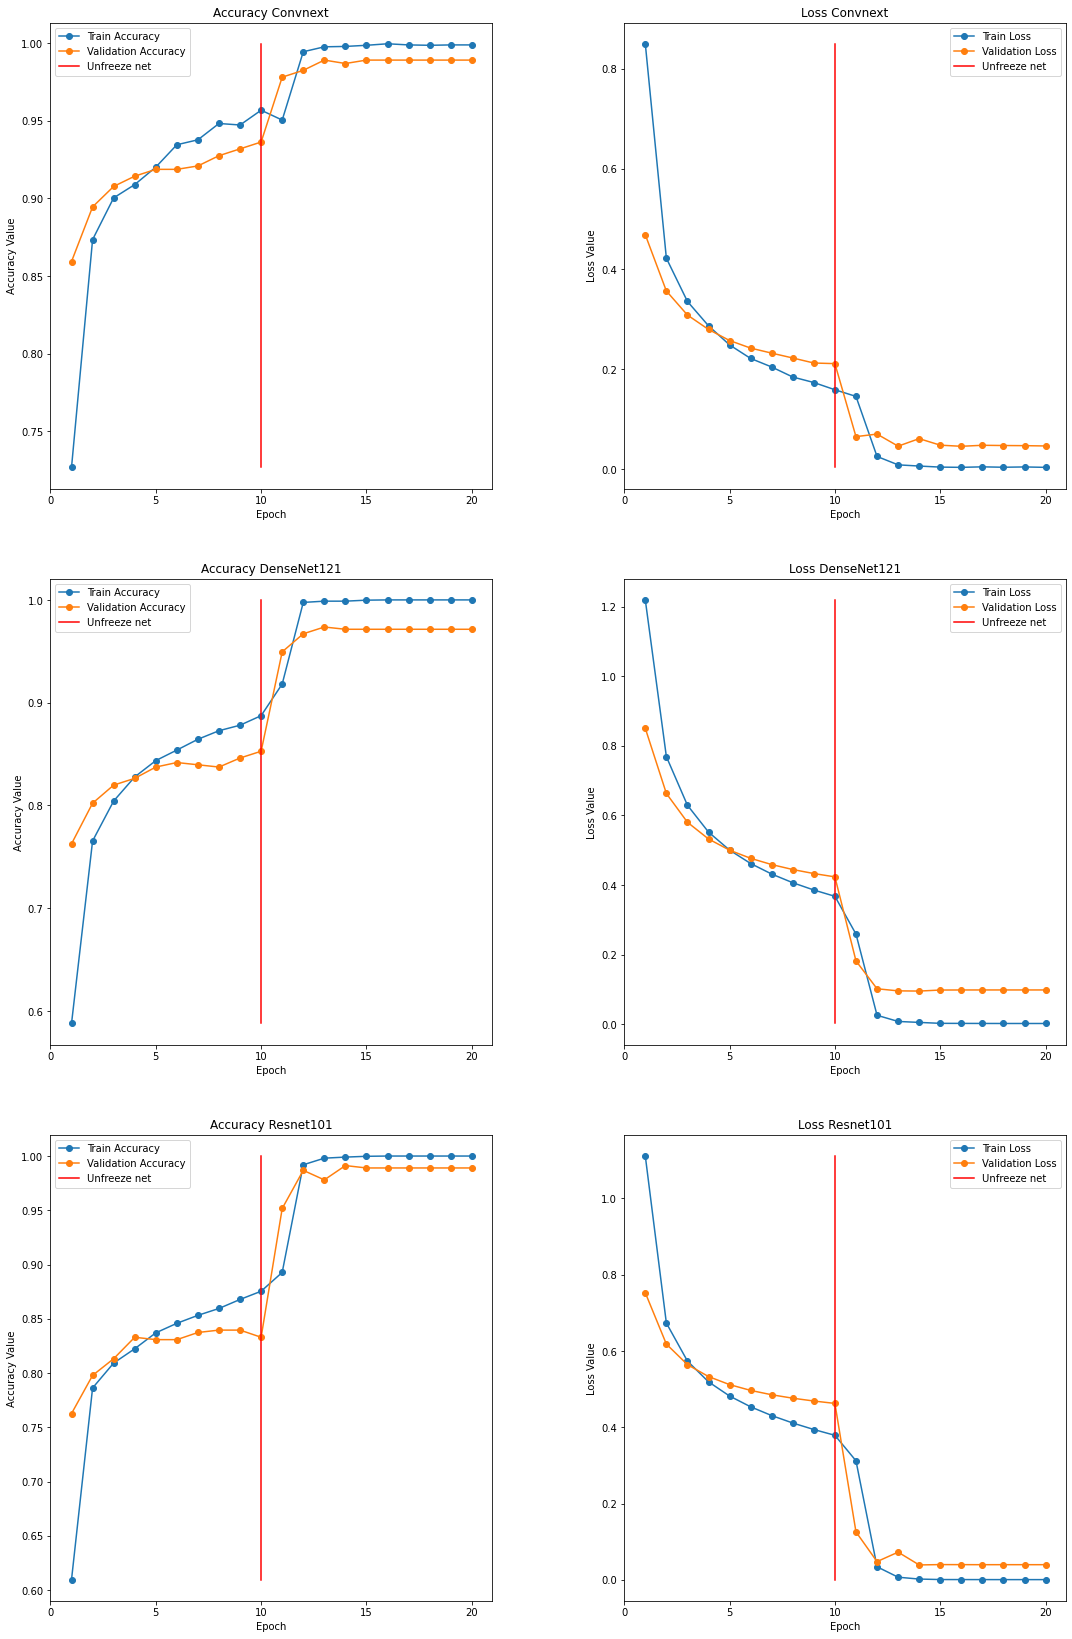

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
modelname = ['Convnext', 'DenseNet121', 'Resnet101']

i=0

for row in range(3):

  epoch_list = list(range(1,epochs*2+1))

  ax[row][0].plot(epoch_list, accuracies['train'][i:20+i], '-o', label='Train Accuracy')
  ax[row][0].plot(epoch_list, accuracies['val'][i:20+i], '-o', label='Validation Accuracy')
  ax[row][0].plot([epochs for x in range(20)],  np.linspace(min(accuracies['train'][i:20+i]).cpu(), max(accuracies['train'][i:20+i]).cpu(), 20), color='r', label='Unfreeze net')
  ax[row][0].set_xticks(np.arange(0, epochs*2+1, 5))
  ax[row][0].set_ylabel('Accuracy Value')
  ax[row][0].set_xlabel('Epoch')
  ax[row][0].set_title('Accuracy {}'.format(modelname[row]))
  ax[row][0].legend(loc="best")

  ax[row][1].plot(epoch_list, losses['train'][i:20+i], '-o', label='Train Loss')
  ax[row][1].plot(epoch_list, losses['val'][i:20+i], '-o',label='Validation Loss')
  ax[row][1].plot([epochs for x in range(20)], np.linspace(min(losses['train'][i:20+i]), max(losses['train'][i:20+i]), 20), color='r', label='Unfreeze net')
  ax[row][1].set_xticks(np.arange(0, epochs*2+1, 5))
  ax[row][1].set_ylabel('Loss Value')
  ax[row][1].set_xlabel('Epoch')
  ax[row][1].set_title('Loss {}'.format(modelname[row]))
  ax[row][1].legend(loc="best")
  fig.tight_layout()
  fig.subplots_adjust(top=1.5, wspace=0.3)

  i+=20

# 5. Test Set Performance

In [28]:
class Ensemble(nn.Module):
    def __init__(self, device):
        super(Ensemble,self).__init__()
        # you should use nn.ModuleList. Optimizer doesn't detect python list as parameters
        self.models = nn.ModuleList(models)
        
    def forward(self, x):
        # it is super simple. just forward num_ models and concat it.
        output = torch.zeros([x.size(0), len(original.classes)]).to(device)
        for model in self.models:
            output += model(x)
        return output

In [29]:
model =  Ensemble(device)

In [30]:
def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}

In [31]:
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}

In [32]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [33]:
model.to(device)
preds,labels = test_predict(model, loaders['test'])

test_loss: 0.0213, test_acc: 0.9980


In [34]:
torch.save(densenet121_0, 'densenet121_0.pth')
torch.save(convnext, 'convnext.pth')
torch.save(resnet101, 'resnet101.pth')

 # 6. Forecast


In [35]:
def norm_out(img):
    
    img = img.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229,0.224,0.225])
    
    img = img*std + mean
        
    return np.clip(img,0,1)

# 7. Metrics and Confusion Metrics

In [36]:
report = classification_report(labels, preds,
                               output_dict=True,
                               target_names=original.classes)
report_df = pd.DataFrame(report).transpose()

In [37]:
pd.set_option("display.max_rows", None)
report_df.head(134)

,precision,recall,f1-score,support
cardboard,1.000000,1.000000,1.000000,64.000000
glass,1.000000,1.000000,1.000000,105.000000
metal,1.000000,1.000000,1.000000,86.000000
paper,0.992126,1.000000,0.996047,126.000000
plastic,1.000000,0.990741,0.995349,108.000000
trash,1.000000,1.000000,1.000000,17.000000
accuracy,0.998024,0.998024,0.998024,0.998024
macro avg,0.998688,0.998457,0.998566,506.000000
weighted avg,0.998039,0.998024,0.998023,506.000000


<Figure size 2880x1440 with 0 Axes>

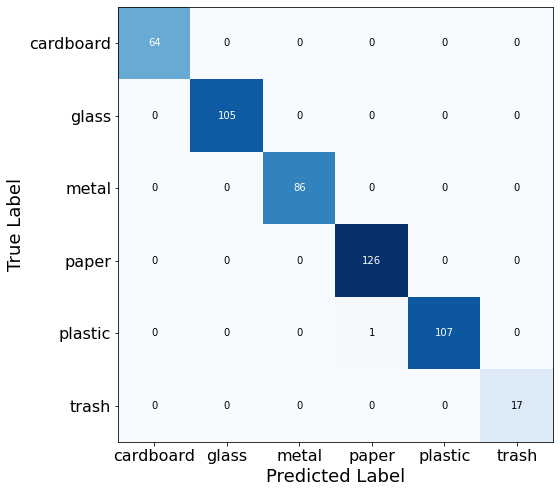

In [38]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(len(original.classes)), original.classes, fontsize=16)
plt.yticks(range(len(original.classes)), original.classes, fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()